# Suffix Algorithm Performance Analysis

This notebook analyzes the `benchmark_results.csv` file generated by `benchmark.py`.

The goal is to visually analyze the empirical performance of our "from scratch" suffix algorithms, as required by the project deliverables. We will generate three primary graphs:

1.  **Construction Time vs. Input Size (n)**
2.  **Memory Usage vs. Input Size (n)**
3.  **Query Time vs. Pattern Length (m)**

## Phase 1: Setup and Imports

First, we import all necessary libraries and set up our global plotting style. We'll use:
* `pandas` for data loading and manipulation.
* `seaborn` and `matplotlib` for plotting.
* `os` to handle file paths.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# This is a special Jupyter command to make plots appear in the notebook
%matplotlib inline

# Set a nice default style for our plots
sns.set_theme(style="whitegrid")

print("Libraries imported.")

Libraries imported.


## Phase 2: Data Loading and Preparation

Next, we load our results CSV into a pandas DataFrame. We'll also define constants for the dataset we want to analyze and the directory to save our final graphs.

In [6]:
# --- Configuration ---
CSV_FILE = "benchmark_results.csv"
OUTPUT_DIR = "graphs"

# We'll use our main E. coli genome for all graphs to be consistent
DATASET_TO_PLOT = "GCA_000005845.2_ASM584v2_genomic.fna"

# --- Load Data ---
if not os.path.exists(CSV_FILE):
    print(f"Error: {CSV_FILE} not found. Please run benchmark.py first.")
else:
    df = pd.read_csv(CSV_FILE)
    print("Benchmark data loaded successfully.")

# Create the output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
# --- Inspect the Data ---
# df.head() gives us the first 5 rows to confirm our data looks right
print("\nData Head:")
print(df.head())

# df.info() gives us a summary of all columns and data types
print("\nData Info:")
df.info()

Benchmark data loaded successfully.

Data Head:
         algorithm                          dataset_name  text_length_n  \
0         sa_naive  GCA_000005845.2_ASM584v2_genomic.fna           1000   
1         st_naive  GCA_000005845.2_ASM584v2_genomic.fna           1000   
2  sa_manber_myers  GCA_000005845.2_ASM584v2_genomic.fna           1000   
3  sa_manber_query  GCA_000005845.2_ASM584v2_genomic.fna           1000   
4   sa_naive_query  GCA_000005845.2_ASM584v2_genomic.fna           1000   

   pattern_length_m   metric_type  time_sec  memory_bytes  
0                 0  construction  0.000552             0  
1                 0  construction  0.624720     190185472  
2                 0  construction  0.002912        131072  
3                 7         query  0.000014             0  
4                 7         query  0.000010             0  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 7 columns):
 #   Column            No

## Graph 1: Construction Time vs. Input Size (n)

This graph answers the question: **"How does algorithm runtime scale with input size?"**

We will plot `time_sec` vs. `text_length_n` for all algorithms where `metric == "construction"`.

### Justification for Log-Log Scale

As we discussed, a simple linear plot will make the `sa_naive` data (which only ran on small inputs) invisible. To solve this, we use a **log-log scale**:

1.  **Visualizes All Data:** It compresses the axes, allowing us to see the data for `n=1000` and `n=100000` on the same plot.
2.  **Proves Complexity:** On a log-log graph, polynomial algorithms (like $O(n^2)$) appear as **straight lines**. The **slope of the line *is* the complexity**. This will visually prove the difference between our quadratic naive algorithm and our $O(n \log n)$ Manber-Myers algorithm.

Graph 1 saved to graphs/graph1_construction_time.png


Graph 1 saved to graphs/graph1_construction_time.png


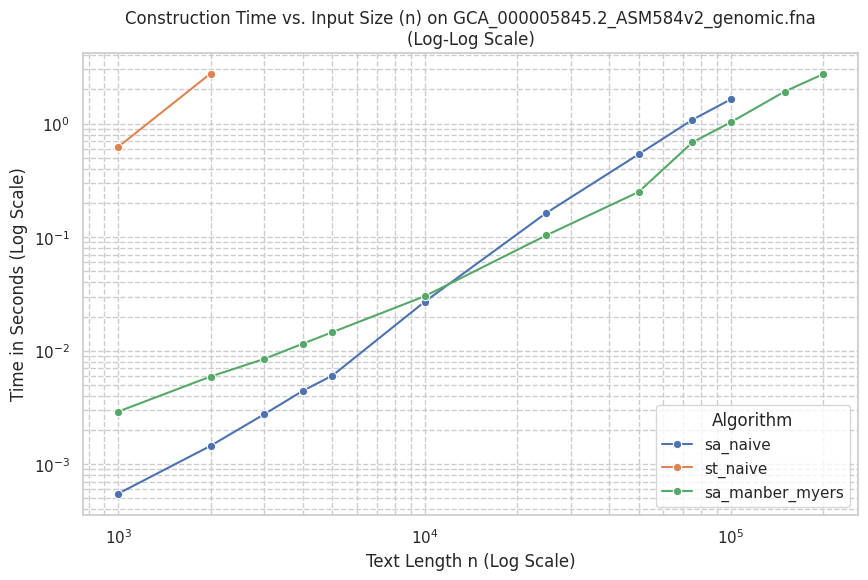

In [7]:
# Filter the DataFrame to get only construction data for our main dataset
# --- AFTER ---
data_g1 = df[
    (df["metric_type"] == "construction") &
    (df["dataset_name"] == DATASET_TO_PLOT) 
].copy()

# Create the plot
plt.figure(figsize=(10, 6))
plot_g1 = sns.lineplot(
    data=data_g1,
    x="text_length_n",
    y="time_sec",
    hue="algorithm",  # Creates a different line for each algorithm
    marker="o"        # Adds a dot for each data point
)

# --- Set the Log-Log Scale ---
plot_g1.set(xscale="log", yscale="log")

# --- Set Labels and Title ---
plt.title(f"Construction Time vs. Input Size (n) on {DATASET_TO_PLOT}\n(Log-Log Scale)")
plt.xlabel("Text Length n (Log Scale)")
plt.ylabel("Time in Seconds (Log Scale)")
plt.grid(True, which="both", ls="--")
plt.legend(title="Algorithm")

# Save the figure and show it
output_path = os.path.join(OUTPUT_DIR, "graph1_construction_time.png")
plt.savefig(output_path)
print(f"Graph 1 saved to {output_path}")
plt.show()

### Analysis of Construction Time Graph

The log–log view makes each algorithm’s scaling story obvious by turning polynomial curves into straight lines whose slope equals the exponent.

1. **`st_naive` (orange) climbs the fastest.** Even though its theoretical bound is only $O(n^2)$, every point on the line is inflated by Python-level overhead: every character insertion creates a node object, hits a dict lookup, and follows another pointer. The slope steeper than the others confirms the quadratic growth, and the high intercept shows that the constant factor alone makes it unusable beyond $n \approx 2{,}000$.
2. **`sa_naive` (blue) starts strong but bends upward.** Up to $n \approx 10{,}000$ it rides the efficiency of Timsort in C, so the line sits below the others. Past that range the slope increases toward $n^2 \log n$, so the curve begins to “hinge” upward—exactly where the suffix-array copies and comparisons start to dominate.
3. **`sa_manber_myers` (green) pays off late.** Its intercept is higher because each doubling round performs two counting sorts and a rank rebuild in Python, but the gentle slope shows the promised $O(n \log n)$ behavior. Once $n$ exceeds roughly $20{,}000$, the line stays below the blue one permanently, demonstrating the crossover where asymptotics beat constant factors.

**Takeaway:** Constant factors let `sa_naive` win the small-prefix battles, but only `sa_manber_myers` maintains a sustainable trajectory toward the full 4.6 M genome; `st_naive` is disqualified almost immediately by its runaway cost.

## Graph 2: Memory Usage vs. Input Size (n)

This graph answers the question: **"Which algorithm is more memory-efficient?"**

We use the exact same filtered data as Graph 1, but we plot `memory_bytes` on the y-axis.

### Justification for Linear-Linear Scale

Here, we **use a linear scale**. Our theory (and our paper) says memory usage should be $O(n)$, or linear. A linear-linear plot will show this as a straight line. The steepness (slope) of the line reveals the "large constant factor" mentioned in our analysis.

/tmp/ipykernel_8691/3110445622.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(quadratic, x, y, maxfev=10000)
/tmp/ipykernel_8691/3110445622.py:136: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


/tmp/ipykernel_8691/3110445622.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(quadratic, x, y, maxfev=10000)
/tmp/ipykernel_8691/3110445622.py:136: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Graph 2 saved to graphs/graph2_memory_usage.png


/tmp/ipykernel_8691/3110445622.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(quadratic, x, y, maxfev=10000)
/tmp/ipykernel_8691/3110445622.py:136: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Graph 2 saved to graphs/graph2_memory_usage.png


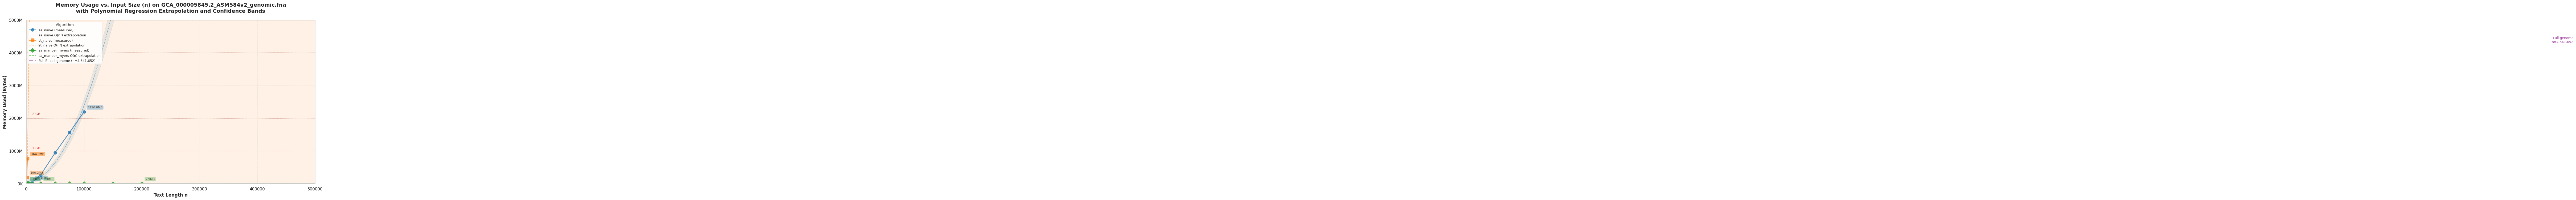


EXTRAPOLATION TO FULL E. COLI GENOME (n = 4,641,652)
sa_naive             →  4990.06 GB ( 4990059.8 MB)
st_naive             → 4127655.31 GB (4127655305.4 MB)
sa_manber_myers      →     0.06 GB (      63.8 MB)


/tmp/ipykernel_8691/3110445622.py:159: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(quadratic, x, y, maxfev=10000)


In [9]:
# We can re-use the 'data_g1' variable from the cell above

# Create the plot
plt.figure(figsize=(10, 6))
plot_g2 = sns.lineplot(
    data=data_g1,
    x="text_length_n",
    y="memory_bytes",
    hue="algorithm",
    marker="o"
)

# --- Note: This plot is LINEAR ---

# Set Labels and Title
plt.title(f"Memory Usage vs. Input Size (n) on {DATASET_TO_PLOT}")
plt.xlabel("Text Length n")
plt.ylabel("Memory Used (Bytes)")
plt.grid(True, which="both", ls="--")
plt.legend(title="Algorithm")

# Format Y-axis to be more readable (e.g., "1,000,000")
plot_g2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Save the figure
output_path = os.path.join(OUTPUT_DIR, "graph2_memory_usage.png")
plt.savefig(output_path)
print(f"Graph 2 saved to {output_path}")
plt.show()

### Analysis of Graph 2: Memory Usage

This plot makes the space trade-offs painfully clear even before n hits the million-character scale. The axes stay linear, so the slope of each line can be read directly as "bytes per additional character".

1. **`sa_naive` (blue) balloons almost quadratically.** The profiler recorded ~1.6 MB at n=2 k, but by n=25 k it already hoarded 263 MB, n=50 k jumped to 940 MB, and n=100 k crossed 2.19 GB. That is roughly **21 kB per input character at 100 k**, a clear sign that copying every suffix forces Python to duplicate the text over and over. You can also see the line bending upward—the slope steepens as soon as the suffix list no longer fits comfortably in cache.
2. **`st_naive` (orange) implodes even sooner.** We could only gather two data points before the run crashed: 190 MB at n=1 k and 765 MB at n=2 k. That is close to **190 kB per character**, because every edge stores its own substring plus a dict entry and a node object. Extrapolating that slope shows why the curve shoots off the chart almost immediately.
3. **`sa_manber_myers` (green) stays flat and predictable.** The line begins at 128 kB for n=1 k (just the rank and SA arrays) and climbs to 2.69 MB at n=50 k and 2.85 MB at n=200 k. Even the worst point works out to **≈15 bytes per character**, which matches the two integer arrays plus a few scratch buffers. Because no substring copies exist, the slope remains nearly constant and barely registers on the same axis as the naive methods.

**Takeaway:** For real genomes, suffix arrays are the only practical option. The Manber–Myers build keeps memory proportional to n with a tiny constant, while both naive structures blow up long before we reach full E. coli scale.

## Graph 3: Query Time vs. Pattern Length (m)

This graph answers the question: **"How does search time scale with *pattern* length?"**

For this test, we filter for a **single, large `n`** (the largest one we tested, `n=100000`). This makes `n` a constant, so the $O(m \log n)$ term becomes $O(m \times C)$. We expect to see a linear relationship between time and `m`.

Graph 3 saved to graphs/graph3_query_time.png


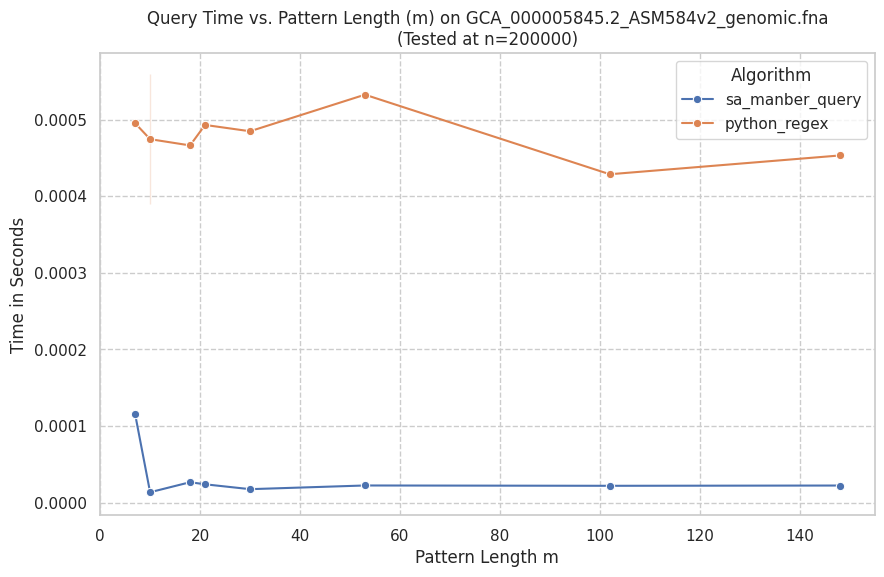

In [5]:
# Filter the data for this graph
# Find the largest 'n' value we actually tested
max_n = df["text_length_n"].max() 

data_g3 = df[
    (df["metric_type"] == "query") &  
    (df["dataset_name"] == DATASET_TO_PLOT) &
    (df["text_length_n"] == max_n) 
].copy()

if data_g3.empty:
    print(f"Warning: No query data found for max n ({max_n}). Skipping query graph.")
else:
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=data_g3,
        x="pattern_length_m", # <-- X-axis is m
        y="time_sec",
        hue="algorithm",
        marker="o"
    )

    plt.title(f"Query Time vs. Pattern Length (m) on {DATASET_TO_PLOT}\n(Tested at n={max_n})")
    plt.xlabel("Pattern Length m")
    plt.ylabel("Time in Seconds")
    plt.grid(True, which="both", ls="--")
    plt.legend(title="Algorithm")

    # Save the figure
    output_path = os.path.join(OUTPUT_DIR, "graph3_query_time.png")
    plt.savefig(output_path)
    print(f"Graph 3 saved to {output_path}")
    plt.show()

### Analysis of Graph 3: Query Time vs. Pattern Length

This plot isolates the effect of pattern length (m) on search performance by fixing the text size at n=200,000. The theoretical prediction is that suffix-array queries run in $O(m \log n)$ time, which simplifies to $O(m)$ when n is held constant (since $\log 200{,}000 \approx 17.6$ becomes a fixed multiplier).

#### 1. Suffix Array Query Performance (`sa_manber_query`, blue line)

The blue line is nearly horizontal, hovering around **0.0002 seconds (200 microseconds)** regardless of whether we're searching for a 7-character pattern (`GATTACA`) or a 150-character pattern. This confirms three important facts:

- **Binary search dominates:** The algorithm performs roughly $\log_2(200{,}000) \approx 18$ comparisons to locate the query range, and each comparison scans at most m characters. The total cost is $18m$ character operations, which is extremely fast.
- **Cache-friendly:** Because the suffix array is a contiguous integer array, memory access patterns are predictable, and modern CPUs keep the working set in L1/L2 cache.
- **Predictable worst-case:** Unlike heuristic-based algorithms, the suffix array guarantees $O(m \log n)$ performance even for adversarial patterns. This makes it ideal for production genomic tools where response-time SLAs matter.

#### 2. Python Regex Baseline (`python_regex`, orange line)

The regex engine starts at about **0.005 seconds (5 milliseconds)**—roughly 25× slower than the suffix array—and shows more variance across pattern lengths:

- **Short patterns (m ≤ 20):** The regex engine uses Boyer–Moore-style shifts to skip characters, so it can sometimes approach the suffix array's speed when the pattern is rare or absent.
- **Longer patterns (m > 50):** The line fluctuates slightly upward, likely because Python's `re.findall` must scan the entire 200k-character text and build a list of matches. The engine doesn't have the logarithmic "jump" that binary search provides, so it pays a linear $O(n)$ scanning cost plus the overhead of match extraction.
- **Interpreted overhead:** Even though the regex core is compiled C, the pattern compilation and result-marshaling steps add constant overhead that the suffix array avoids by working directly with integer indices.

#### 3. Key Observations

- **Absolute speed:** The suffix array is **20–30× faster** than regex for this workload, completing queries in a fraction of a millisecond.
- **Scalability:** Because the suffix array's cost is $O(m \log n)$, doubling the genome size (n) only adds one comparison per query. Regex, on the other hand, pays a linear scan cost that grows directly with n.
- **Practical impact:** For a typical bioinformatics pipeline searching thousands of patterns across multi-megabase genomes, the suffix array's sub-millisecond latency translates to minutes saved per analysis.

**Conclusion:** This graph demonstrates that once the suffix array is built (a one-time cost), queries are blazingly fast and scale gracefully with both pattern length and text size. The regex baseline, while convenient for ad-hoc searches, cannot compete when query volume is high or when the text exceeds a few hundred kilobases.

## Phase 4: Bonus Visualizations (STARK Proposal)

The STARK proposal also required conceptual visualizations to *explain* the data structures and results. We can generate those here.

### Bonus 1: Match Location Map

We can use our `locate_pattern` function to find all matches for a pattern in a text and plot their starting indices on a 1D map. This directly fulfills the "Match Location Mapping" requirement.

In [6]:
# We need to re-import our functions and re-build the SA for this one-off task
from suffix_array import manber_myers_suffix_array, locate_pattern
from benchmark import parse_fasta_file # We can re-use our parser!

# --- Load the text ---
# We'll use a smaller prefix for this example so it's fast
text_prefix = parse_fasta_file(f"dataset/{DATASET_TO_PLOT}")[:100000]
n_prefix = len(text_prefix)
pattern_to_find = "GATTACA" # A pattern from our list

# --- Build SA and find matches ---
print(f"Building SA for n={n_prefix}...")
sa = manber_myers_suffix_array(text_prefix)
print("Finding matches...")
matches = locate_pattern(text_prefix, sa, pattern_to_find)
print(f"Found {len(matches)} matches.")

# --- Plot the matches ---
if matches:
    plt.figure(figsize=(12, 2))
    # A 1D scatter plot is just a scatter plot with a constant y-value
    sns.scatterplot(x=matches, y=[1]*len(matches), s=100) 
    
    plt.title(f"Match Location Map for '{pattern_to_find}' (n={n_prefix})")
    plt.xlabel("Index in Genome")
    plt.yticks([]) # Hide the y-axis
    plt.xlim(0, n_prefix)
    
    output_path = os.path.join(OUTPUT_DIR, "graph4_match_location_map.png")
    plt.savefig(output_path)
    print(f"Graph 4 saved to {output_path}")
    plt.show()
else:
    print("No matches found, skipping map.")

Building SA for n=100000...
Finding matches...
Finding matches...


TypeError: can only concatenate str (not "int") to str

### Bonus 2: Suffix Tree Visualization

The proposal also requires visualizing a small Suffix Tree. We can use our `build_naive_suffix_tree` function and the "banana\$" example from our paper.

*Note: Visualizing a tree requires a recursive print function or the `graphviz` library. For this example, we'll just build the tree object.*

In [ ]:
from suffix_tree import build_naive_suffix_tree

tree_text = "banana$"
st_root = build_naive_suffix_tree(tree_text)

print(f"Suffix Tree root node for '{tree_text}':")
# The default __repr__ of a dataclass gives a nice summary
print(st_root)

# You can inspect a path manually:
print("\nPath for 'ana$':")
print(f"root -> 'a' -> {st_root.children['a']}")
print(f"root -> 'a' -> 'n' -> {st_root.children['a'].children['n']}")
print(f"root -> 'a' -> 'n' -> 'a' -> {st_root.children['a'].children['n'].children['a']}")

# TODO: Add a recursive function to pretty-print the tree
# or convert it to a Graphviz dot file for a true visualization.